# Importing Libraries

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning (TensorFlow and Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Image preprocessing
from tensorflow.keras.utils import Sequence  # For custom data generators
from tensorflow.keras.applications import ResNet50  # Pretrained CNN model
from tensorflow.keras.applications.resnet50 import preprocess_input  # Standard preprocessing for ResNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Model architecture layers
from tensorflow.keras.optimizers import Adam  # Optimizer for model training

# Machine learning utilities
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.preprocessing import LabelEncoder  # To encode categorical labels
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

# Configurations and Constants

In [3]:
# Image dimensions for ResNet50 input
IMG_SIZE = (224, 224)  

# Number of images processed per batch during training
BATCH_SIZE = 32  

# Number of epochs to train the model
EPOCHS = 10  

# Random seed for reproducibility
SEED = 42  

# Base directory containing the dataset
BASE_DIR = r'C:\Users\prith\Downloads\autism_dataset'


# Metadata creation

In [4]:
def create_metadata_dataframe(base_dir):
    data = []
    for condition in os.listdir(base_dir):
        condition_path = os.path.join(base_dir, condition)
        if not os.path.isdir(condition_path):
            continue
        for severity in os.listdir(condition_path):
            severity_path = os.path.join(condition_path, severity)
            if not os.path.isdir(severity_path):
                continue
            for age_group in os.listdir(severity_path):
                age_path = os.path.join(severity_path, age_group)
                if not os.path.isdir(age_path):
                    continue
                for activity in os.listdir(age_path):
                    activity_path = os.path.join(age_path, activity)
                    if not os.path.isdir(activity_path):
                        continue
                    for img_file in os.listdir(activity_path):
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(activity_path, img_file)
                            data.append({
                                'filepath': img_path,
                                'condition': condition,
                                'severity': severity,
                                'age_group': age_group,
                                'activity': activity,
                                'filename': img_file
                            })
    df = pd.DataFrame(data)
    df['age_min'] = df['age_group'].str.extract(r'(\d+)').astype(float)
    df['has_autism'] = df['condition'].apply(lambda x: 'no' if x == 'Non-ASD' else 'yes')
    activity_mapping = {
        'Handwriitng': 'Handwriting',
        'Handwritng': 'Handwriting',
        'handwriting': 'Handwriting'
    }
    df['activity'] = df['activity'].replace(activity_mapping)
    return df

metadata_df = create_metadata_dataframe(BASE_DIR)

# EDA

In [5]:
# Basic info
print("Metadata shape:", metadata_df.shape)
print("\nColumns:", metadata_df.columns)

# Preview
print("\nFirst few rows of metadata:")
print(metadata_df.head())


Metadata shape: (1708, 8)

Columns: Index(['filepath', 'condition', 'severity', 'age_group', 'activity',
       'filename', 'age_min', 'has_autism'],
      dtype='object')

First few rows of metadata:
                                            filepath condition severity  \
0  C:\Users\prith\Downloads\autism_dataset\ASD\Mi...       ASD     Mild   
1  C:\Users\prith\Downloads\autism_dataset\ASD\Mi...       ASD     Mild   
2  C:\Users\prith\Downloads\autism_dataset\ASD\Mi...       ASD     Mild   
3  C:\Users\prith\Downloads\autism_dataset\ASD\Mi...       ASD     Mild   
4  C:\Users\prith\Downloads\autism_dataset\ASD\Mi...       ASD     Mild   

   age_group  activity                 filename  age_min has_autism  
0  3-6 years  Coloring    IMG20240401134437.jpg      3.0        yes  
1  3-6 years  Coloring    IMG20240401134937.jpg      3.0        yes  
2  3-6 years  Coloring  IMG_20240401_134123.jpg      3.0        yes  
3  3-6 years  Coloring  IMG_20240401_134315.jpg      3.0        yes 


Class distribution in metadata:
has_autism
yes    1143
no      565
Name: count, dtype: int64


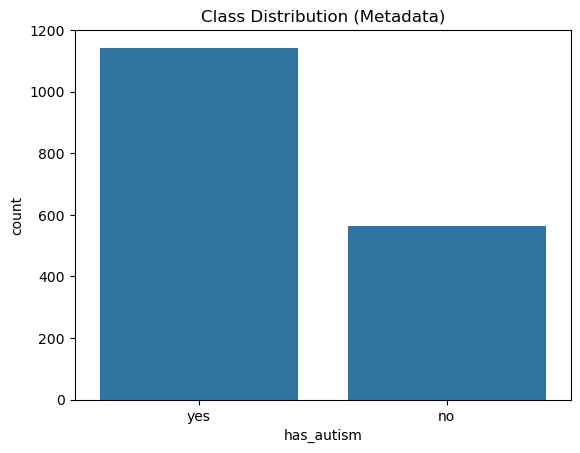


Severity distribution:
severity
Normal      565
Mild        384
Moderate    381
Severe      378
Name: count, dtype: int64


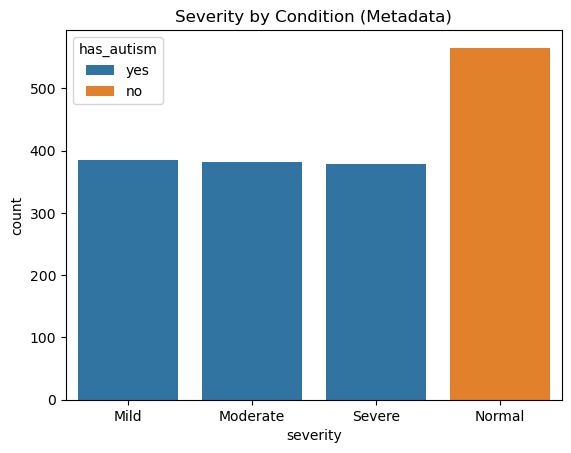


Age group distribution:
age_group
9-12 years    572
6-9 years     569
3-6 years     567
Name: count, dtype: int64


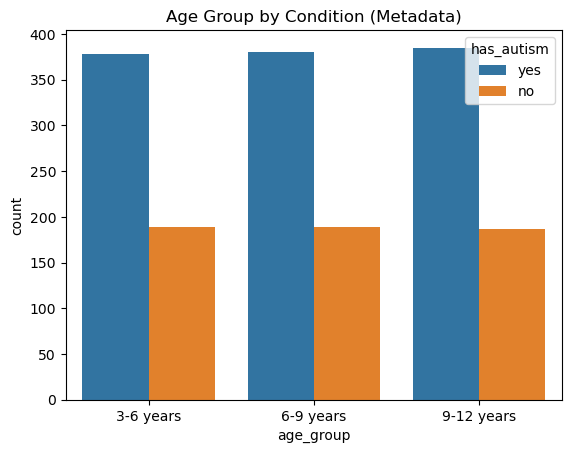


Activity distribution:
activity
Drawing        571
Handwriting    569
Coloring       568
Name: count, dtype: int64


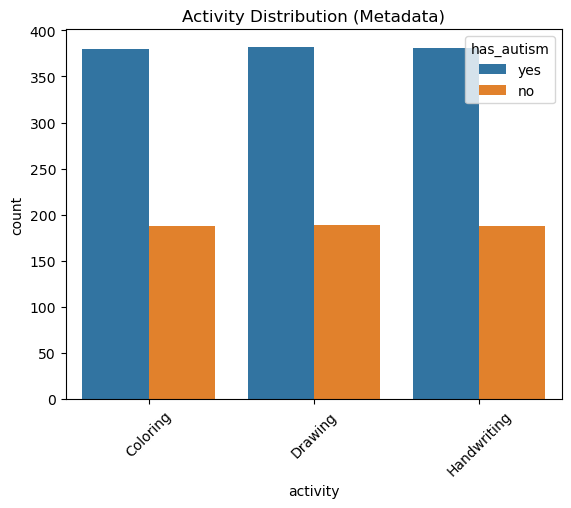

In [6]:
# Class distribution
if 'has_autism' in metadata_df.columns:
    print("\nClass distribution in metadata:")
    print(metadata_df['has_autism'].value_counts())
    sns.countplot(data=metadata_df, x='has_autism')
    plt.title("Class Distribution (Metadata)")
    plt.show()

# Severity distribution
if 'severity' in metadata_df.columns:
    print("\nSeverity distribution:")
    print(metadata_df['severity'].value_counts())
    sns.countplot(data=metadata_df, x='severity', hue='has_autism')
    plt.title("Severity by Condition (Metadata)")
    plt.show()

# Age group distribution
if 'age_group' in metadata_df.columns:
    print("\nAge group distribution:")
    print(metadata_df['age_group'].value_counts())
    sns.countplot(data=metadata_df, x='age_group', hue='has_autism')
    plt.title("Age Group by Condition (Metadata)")
    plt.show()

# Activity distribution
if 'activity' in metadata_df.columns:
    print("\nActivity distribution:")
    print(metadata_df['activity'].value_counts())
    sns.countplot(data=metadata_df, x='activity', hue='has_autism')
    plt.title("Activity Distribution (Metadata)")
    plt.xticks(rotation=45)
    plt.show()


# Model Building

In [7]:
# Custom Data Generator
# Custom data generator class for Autism Spectrum Disorder (ASD) image dataset.
# Extends Keras' Sequence class to enable multi-threaded, batch-wise data loading.
class ASDDataset(Sequence):
    def __init__(self, dataframe, label_encoder, batch_size=BATCH_SIZE, shuffle=True):
        self.data = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_encoder = label_encoder
        self.data['encoded_label'] = self.label_encoder.transform(self.data['has_autism'])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []
        for _, row in batch_data.iterrows():
            img = load_img(row['filepath'], target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            images.append(img_array)
            labels.append(row['encoded_label'])
        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)

In [8]:
# Prepare Data
metadata_df = create_metadata_dataframe(BASE_DIR)
label_encoder = LabelEncoder()
label_encoder.fit(metadata_df['has_autism'])

train_df, test_df = train_test_split(
    metadata_df, test_size=0.2, random_state=SEED, stratify=metadata_df['has_autism']
)

train_dataset = ASDDataset(train_df, label_encoder)
test_dataset = ASDDataset(test_df, label_encoder, shuffle=False)

In [9]:
# Build Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
print("Starting Training...")
model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

# Evaluate Model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save Model
model.save("resnet50_asd_gestures_tf.h5")
np.save("label_classes.npy", label_encoder.classes_)

# Logging
print("\nDataset Information:")
print(f"Total Images: {len(metadata_df)}")
print(f"Training Images: {len(train_df)}")
print(f"Testing Images: {len(test_df)}")
print("\nClass Distribution:")
print(metadata_df['has_autism'].value_counts(normalize=True))

Starting Training...


C:\Users\prith\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 578s 11s/step - accuracy: 0.8887 - loss: 0.3231 - val_accuracy: 0.3304 - val_loss: 235360.8906
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 362s 8s/step - accuracy: 0.8975 - loss: 0.4413 - val_accuracy: 0.6696 - val_loss: 42268.4609
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.9114 - loss: 0.2629 - val_accuracy: 0.7456 - val_loss: 4.5449
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 346s 8s/step - accuracy: 0.9290 - loss: 0.1817 - val_accuracy: 0.7193 - val_loss: 27.5949
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 339s 8s/step - accuracy: 0.9414 - loss: 0.1534 - val_accuracy: 0.9035 - val_loss: 0.3942
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 357s 8s/step - accuracy: 0.9539 - loss: 0.1262 - val_accuracy: 0.9123 - val_loss: 0.2514
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 354s 8s/step - accuracy: 0.9561 - loss: 0.1146 - val_accuracy: 0.9474 - val_loss: 0.1803
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 366s 8s/step - accuracy: 0.9612 - loss: 0.1089 - val_accuracy:

Test Accuracy: 80.99%

Dataset Information:
Total Images: 1708
Training Images: 1366
Testing Images: 342

Class Distribution:
has_autism
yes    0.669204
no     0.330796
Name: proportion, dtype: float64


# Model Evaluation

In [ ]:
# Evaluate model performance on the test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate predictions on the test dataset
y_true = test_dataset.data['encoded_label'].values
y_pred_proba = model.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC and Precision-Recall curves (only for binary classification)
if len(label_encoder.classes_) == 2:
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    RocCurveDisplay.from_predictions(y_true, y_pred_proba[:, 1])
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_pred_proba[:, 1])
    plt.show()

# Error analysis to understand model misclassifications
errors = test_dataset.data.copy()
errors['true'] = y_true
errors['pred'] = y_pred
errors['correct'] = errors['true'] == errors['pred']

print("\nIncorrect Predictions Sample:")
print(errors[errors['correct'] == False].head())

# False negatives and false positives summary
fn = errors[(errors['true'] == 1) & (errors['pred'] == 0)]
fp = errors[(errors['true'] == 0) & (errors['pred'] == 1)]

print(f"\nFalse Negatives (missed autism cases): {len(fn)}")
print(f"False Positives (wrongly flagged autism): {len(fp)}")

# Subgroup accuracy analysis by columns such as age group, severity, and activity
def subgroup_accuracy(df, subgroup_col):
    """Calculate accuracy for each subgroup."""
    results = df.groupby(subgroup_col).apply(lambda x: (x['true'] == x['pred']).mean())
    return results

# Accuracy by age group
if 'age_group' in errors.columns:
    age_acc = subgroup_accuracy(errors, 'age_group')
    plt.figure(figsize=(6, 4))
    sns.barplot(x=age_acc.index, y=age_acc.values)
    plt.title("Accuracy by Age Group")
    plt.ylabel("Accuracy")
    plt.xlabel("Age Group")
    plt.ylim(0, 1)
    plt.show()
    print("\nAccuracy by Age Group:\n", age_acc)

# Accuracy by severity
if 'severity' in errors.columns:
    sev_acc = subgroup_accuracy(errors, 'severity')
    plt.figure(figsize=(6, 4))
    sns.barplot(x=sev_acc.index, y=sev_acc.values)
    plt.title("Accuracy by Severity")
    plt.ylabel("Accuracy")
    plt.xlabel("Severity")
    plt.ylim(0, 1)
    plt.show()
    print("\nAccuracy by Severity:\n", sev_acc)

# Accuracy by activity type
if 'activity' in errors.columns:
    act_acc = subgroup_accuracy(errors, 'activity')
    plt.figure(figsize=(6, 4))
    sns.barplot(x=act_acc.index, y=act_acc.values)
    plt.title("Accuracy by Activity")
    plt.ylabel("Accuracy")
    plt.xlabel("Activity")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()
    print("\nAccuracy by Activity:\n", act_acc)


11/11 ━━━━━━━━━━━━━━━━━━━━ 76s 7s/step - accuracy: 0.8099 - loss: 0.4228 

Test Loss: 0.4228
Test Accuracy: 80.99%
